# Compute KDM Biological Age in SardiNIA and InCHIANTI

KDM model implemented by:

o	https://github.com/elisawarner/Biological-Age-Project 

Original model's 10 biomarkers from here:

o	https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3660119/pdf/gls233.pdf 


The 10 biomarkers are:

- C-reactive protein
- Creatinine
- Glycated hemoglobin
- Albumin [Too many missing in SardiNIA]
- Total cholesterol
- Cytomegalovirus optical density [NOT AVAILABLE]
- Alkaline phosphatase [Not available in SardiNIA]
- Forced expiratory volume [NOT AVAILABLE]
- Urea nitrogen
- Systolic blood pressure

In [85]:
import bio_age as BA  # import script
import pandas as pd
import numpy as np

In [86]:
# read in SardiNIA and InCHIANTI data and format correctly
sard_df = pd.read_csv("RawData/2013-12-18-Sardinia-CleanUp-Data-Wave1.tsv", sep="\t")

inch_df0 = pd.read_csv("RawData/inChiantiAll-w0.tsv", sep="\t")
inch_df3 = pd.read_csv("RawData/inChiantiAll-w3.tsv", sep="\t")

In [87]:
# make sex all ones to avoid stratification by sex
sard_df["Sex"] = np.ones(sard_df.shape[0])
inch_df0["Sex"] = np.ones(inch_df0.shape[0])
inch_df3["Sex"] = np.ones(inch_df3.shape[0])

In [92]:
# select all relevant columns
sard_cols = ["Age","Sex","id_individual","assayhsCRP", "labsCreatinina", "labsHbA1C", "labsColesterolo", "labsAzotemia", "exmBPsys_jbs"] # "labsAlbumina", "SpirometerPrFEV1" 
inch_cols = ["Age","Sex","id_individual","CRP_HS", "CREA", "HB", "ALB", "COLTOT", "PALK", "BUN", "23_V18"]

sard_df_KDM = sard_df[sard_cols].copy()
inch_df0_KDM = inch_df0[inch_cols].copy()
inch_df3_KDM = inch_df3[inch_cols].copy()

# add uniform weight column
sard_df_KDM = sard_df_KDM.assign(sample_weight=np.ones(sard_df_KDM.shape[0]))
inch_df0_KDM = inch_df0_KDM.assign(sample_weight=np.ones(inch_df0_KDM.shape[0]))
inch_df3_KDM = inch_df3_KDM.assign(sample_weight=np.ones(inch_df3_KDM.shape[0]))

# drop NAs
sard_df_KDM = sard_df_KDM.dropna()
inch_df0_KDM = inch_df0_KDM.dropna()
inch_df3_KDM = inch_df3_KDM.dropna()

In [93]:
sard_df_KDM.shape

(3274, 10)

### Compute KDM age

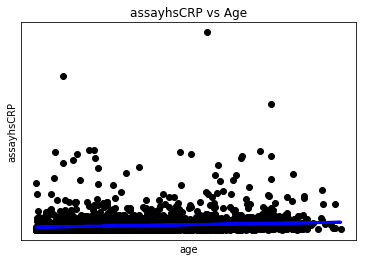

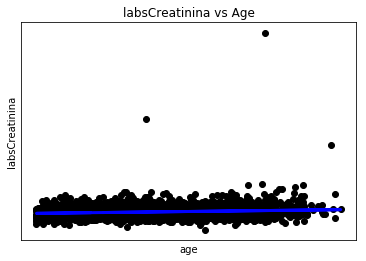

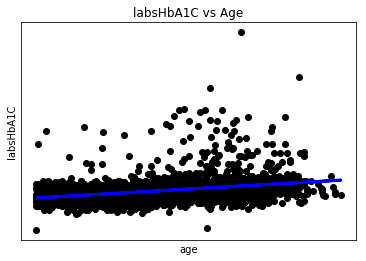

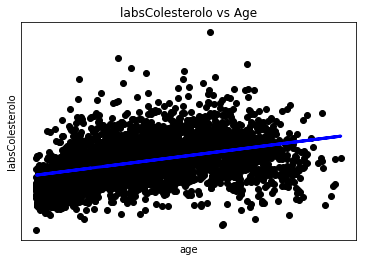

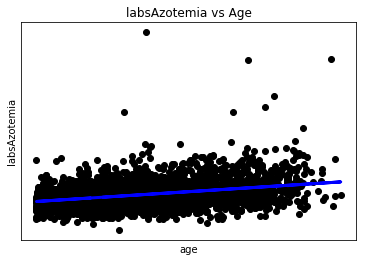

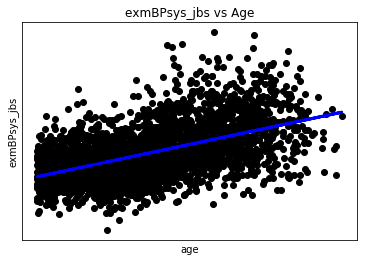

In [94]:
# run KDM model to get BAs
model = BA.Methods(sard_df_KDM, "cachename", age = 0, genderindex = 1, primarykey = 2, samp_wt = sard_df_KDM.shape[1]-1, output="KDM_sardinia.csv")
resultsS = model.KDM() # run model`

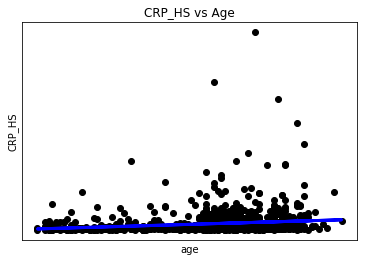

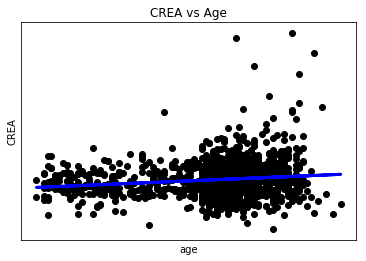

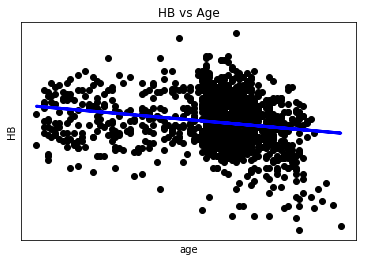

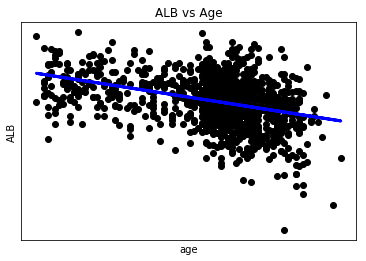

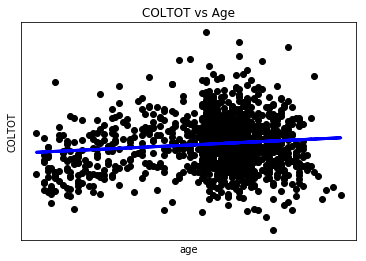

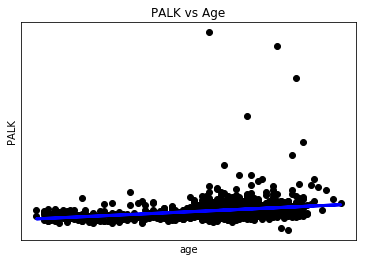

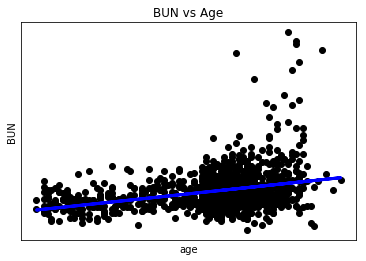

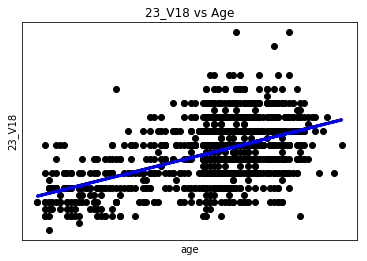

In [95]:
# run KDM model to get BAs
model0 = BA.Methods(inch_df0_KDM, "cachename0", age = 0, genderindex = 1, primarykey = 2, samp_wt = inch_df0_KDM.shape[1]-1, output="KDM_inchianti.csv")
resultsI0 = model0.KDM() # run model`

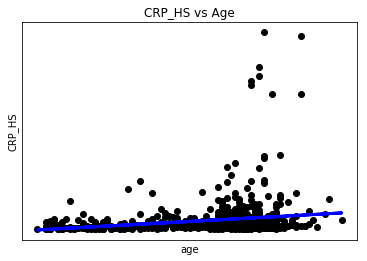

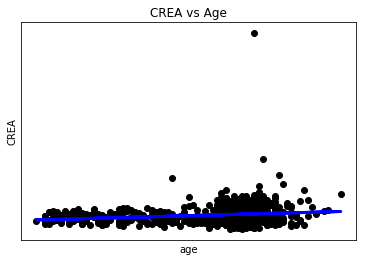

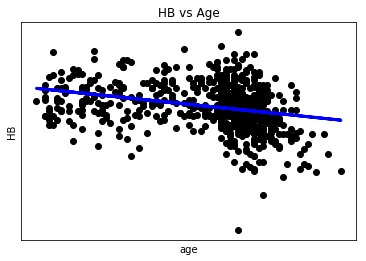

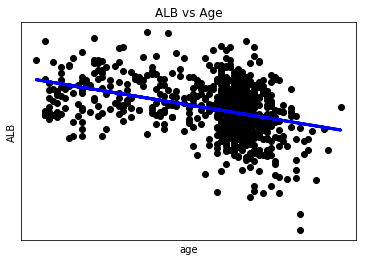

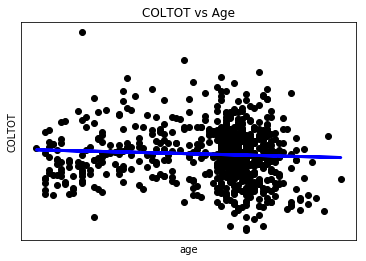

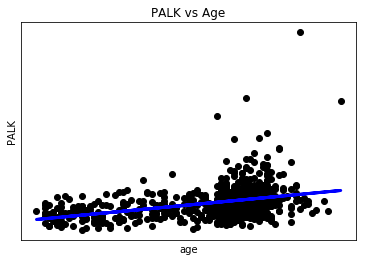

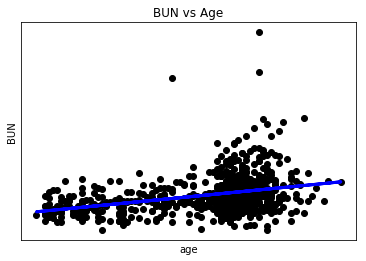

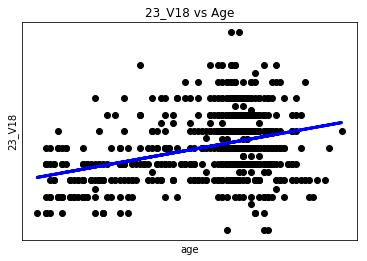

In [96]:
# run KDM model to get BAs
model3 = BA.Methods(inch_df3_KDM, "cachename3", age = 0, genderindex = 1, primarykey = 2, samp_wt = inch_df3_KDM.shape[1]-1, output="KDM_inchianti3.csv")
resultsI3 = model3.KDM() # run model`

In [97]:
sard_results_df = pd.DataFrame(resultsS[1:], columns=resultsS[0])[['id_individual','Age','BA','BAC']]
sard_results_df.to_csv('KDM_sardinia_biological_age.csv',index=False)

### Combine inCHIANTI results with epigenetic age file

In [100]:
inch0_results_df = pd.DataFrame(resultsI0[1:], columns=resultsI0[0])[['id_individual','Age','BA','BAC']]
inch3_results_df = pd.DataFrame(resultsI3[1:], columns=resultsI3[0])[['id_individual','Age','BA','BAC']]

In [101]:
# read in epigenetics results files
DNAm_data = pd.read_csv('InChianti_baseline_FollowUp3_DNAm.csv')

# combine data files
BA_col = []
BAC_col = []
for i in range(DNAm_data.shape[0]):
    subjid = str(float(DNAm_data['subjid'][i]))
    visit = DNAm_data['visit'][i]
    if visit == "baseline":
        if subjid in list(inch0_results_df['id_individual']):
            BA_col.append(float(inch0_results_df.loc[inch0_results_df['id_individual']==subjid]['BA']))
            BAC_col.append(float(inch0_results_df.loc[inch0_results_df['id_individual']==subjid]['BAC']))
        else:
            BA_col.append(float('nan'))
            BAC_col.append(float('nan'))
    else:
        if subjid in list(inch3_results_df['id_individual']):
            BA_col.append(float(inch3_results_df.loc[inch3_results_df['id_individual']==subjid]['BA']))
            BAC_col.append(float(inch3_results_df.loc[inch3_results_df['id_individual']==subjid]['BAC']))
        else:
            BA_col.append(float('nan'))
            BAC_col.append(float('nan'))

In [102]:
# save results
DNAm_data = DNAm_data.assign(BA = BA_col)
DNAm_data = DNAm_data.assign(BAC = BAC_col)
DNAm_data = DNAm_data.dropna()

DNAm_data.to_csv('InChianti_baseline_FollowUp3_DNAm_KDM.csv',index=False)

### Correlation with age

In [103]:
from scipy.stats import pearsonr

print("SardiNIA W0")
r, p = pearsonr(np.array(sard_results_df['BA']).astype(np.float), np.array(sard_results_df['Age']).astype(np.float))
print(r**2)

print("InCHIANTI W0")
r, p = pearsonr(np.array(inch0_results_df['BA']).astype(np.float), np.array(inch0_results_df['Age']).astype(np.float))
print(r**2)

print("InCHIANTI W3")
r, p = pearsonr(np.array(inch3_results_df['BA']).astype(np.float), np.array(inch3_results_df['Age']).astype(np.float))
print(r**2)

SardiNIA W0
0.41215480507845853
InCHIANTI W0
0.37091902032209406
InCHIANTI W3
0.3512782705838336


In [104]:
print("SardiNIA W0")
r, p = pearsonr(np.array(sard_results_df['BAC']).astype(np.float), np.array(sard_results_df['Age']).astype(np.float))
print(r**2)

print("InCHIANTI W0")
r, p = pearsonr(np.array(inch0_results_df['BAC']).astype(np.float), np.array(inch0_results_df['Age']).astype(np.float))
print(r**2)

print("InCHIANTI W3")
r, p = pearsonr(np.array(inch3_results_df['BAC']).astype(np.float), np.array(inch3_results_df['Age']).astype(np.float))
print(r**2)

SardiNIA W0
0.9977523720211882
InCHIANTI W0
0.9893816337231561
InCHIANTI W3
0.9860965014378811
